In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
import sys
MY_DRIVE_PATH = '/content/drive/MyDrive/Technion/Diffusion-AD-Project/'
sys.path.append(MY_DRIVE_PATH)
os.chdir(MY_DRIVE_PATH)

Mounted at /content/drive


In [2]:
!pip install blobfile &> /dev/null
!pip install mpi4py &> /dev/null
!pip install pytorch-lightning &> /dev/null

In [3]:
import pytorch_lightning as pl
from IPython.display import Markdown as md
from utils.models import ModelLoader
from utils.noiser import *
from utils.denoiser import *
from utils.error_map import *
from utils.anomaly_scorer import *
from utils.results_manager import ResultsManager
from core.diffusion_ad import DiffusionAD
from extern.guided_diffusion.guided_diffusion.unet import UNetModel
from extern.guided_diffusion.guided_diffusion import gaussian_diffusion as gd
from config.configuration import DIFFUSION_AD_HPARAMS, DIFFUSION_AD_REQUIRED_HPARAMS, CATEGORY_TO_NOISE_TIMESTEPS

In [4]:
model: UNetModel = None

# **<u>Initialize Experiment</u>**

First, we load and construct all the needed objects for our experiment.

In [5]:
if not model:
    model, diffusion = ModelLoader().get_model('256x256_uncond')

In [6]:
noiser = TimestepUniformNoiser(diffusion)
denoiser = ModelTimestepUniformDenoiser(model, diffusion)
anomaly_map_generator = BatchFilteredSquaredError()
anomaly_scorer = MaxValueAnomalyScorer()
results_manager = ResultsManager()

In [7]:
diffusion_ad = DiffusionAD(noiser,
                           denoiser,
                           anomaly_map_generator,
                           anomaly_scorer,
                           DIFFUSION_AD_HPARAMS)
diffusion_ad.args.verbosity = 2

In [8]:
trainer = {
    category: pl.Trainer.from_argparse_args(diffusion_ad.args, 
                                            default_root_dir=os.path.join(diffusion_ad.args.root_output_dir, category), 
                                            max_epochs=diffusion_ad.args.num_epochs,
                                            accelerator='gpu',
                                            devices=1) \
           for category in CATEGORY_TO_NOISE_TIMESTEPS.keys()
}

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utili

# **<u>Run Experiment</u>**

## **<u>Object Categories</u>**

First, we will run the evaluation on the different object categories.

In [9]:
OBJECT_CATEGORIES = [
    'hazelnut'
]

md(f'**<u>The object categories are:</u>**\n\n{OBJECT_CATEGORIES}')

**<u>The object categories are:</u>**

['hazelnut']

INFO:lightning_fabric.accelerators.cuda:You are using a CUDA device ('A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

img min: tensor(-1., device='cuda:0') img max: tensor(1., device='cuda:0')
Transformed input image:


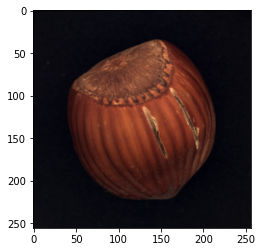

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/263 [00:00<?, ?it/s]

Reconstructed image No. 1:


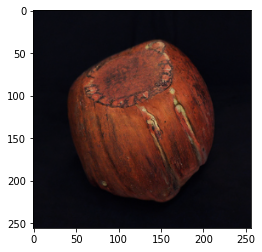

  0%|          | 0/266 [00:00<?, ?it/s]

Reconstructed image No. 2:


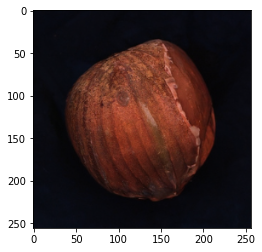

  0%|          | 0/225 [00:00<?, ?it/s]

Reconstructed image No. 3:


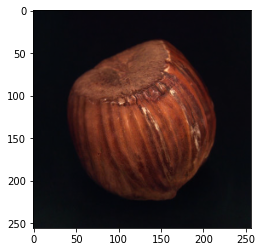

Anomaly Map values:
vmin=0.0002657121678192048, vmax=0.4131158661411427
img min: tensor(-1., device='cuda:0') img max: tensor(1., device='cuda:0')
Transformed input image:


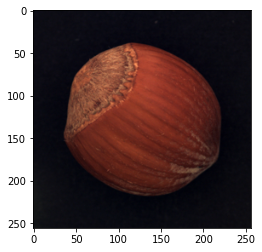

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

Reconstructed image No. 1:


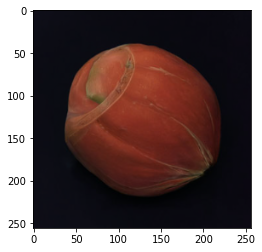

  0%|          | 0/266 [00:00<?, ?it/s]

Reconstructed image No. 2:


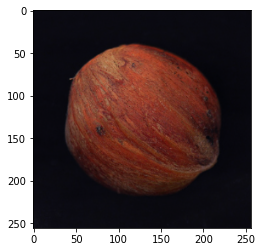

  0%|          | 0/255 [00:00<?, ?it/s]

Reconstructed image No. 3:


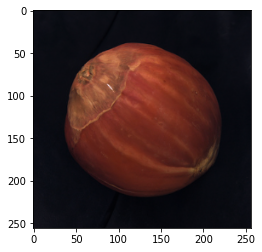

Anomaly Map values:
vmin=0.00030345444065291865, vmax=0.3855351262044978
Total pixel-level auc-roc score :
0.9811096858689253
Total image-level auc-roc score :
1.0
test_epoch_end
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         img_auc                    1.0
        pixel_auc           0.9811096787452698
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [10]:
remaining_categories = results_manager.get_remaining_categories()

for category in OBJECT_CATEGORIES:
    if category in remaining_categories:
        print(f'Evaluating category: {category}')
        diffusion_ad.args.category = category
        trainer[category].test(diffusion_ad)

## **<u>Texture Categories</u>**

Now, we will run the evaluation on the different texture categories.

In [ ]:
TEXTURE_CATEGORIES = [
    'tile'
]

md(f'**<u>The texture categories are:</u>**\n\n{TEXTURE_CATEGORIES}')

In [ ]:
remaining_categories = results_manager.get_remaining_categories()

for category in TEXTURE_CATEGORIES:
    if category in remaining_categories:
        print(f'Evaluating category: {category}\n')
        diffusion_ad.args.category = category
        trainer[category].test(diffusion_ad)